# Single-Layer Perceptron
 
Binary classification using with Kaggle Breast Cancer Wisconsin data (benign/malignant)
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
 
In this notebook we rebuild a classic perceptron pipeline from scratch to demystify the end-to-end workflow: loading the raw medical dataset, normalising the features, training a pocket/averaged perceptron, and interpreting the results with basic diagnostics and PCA visualisation.
 
The emphasis is on understanding each numerical step rather than relying on high-level libraries—perfect for revisiting foundational linear classifiers.

## Load and parse the dataset
 
We start by importing the raw CSV provided by the UCI/Kaggle Breast Cancer Wisconsin dataset. The file contains patient-level measurements (radius, texture, smoothness, etc.), an identifier column, and the diagnosis label indicating whether the tumour is benign or malignant.
 
The preprocessing goal here is minimal but essential: drop the non-informative identifier columns, handle missing values defensively, and encode the categorical diagnosis column into a binary numerical target.

In [ ]:
# Core numerical tooling for tabular processing and vector math
import pandas as pd
import numpy as np

In [ ]:
file_path = "../datasets/breast-cancer-wisconsin-data.csv"

# Load dataset
df = pd.read_csv(file_path)

# Drop unnecessary columns
df = df.drop(columns=['id', 'Unnamed: 32'], errors='ignore')  
df = df.dropna()

# Encode labels: M = 1 (malignant), B = 0 (benign)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Split into features and target
X = df.drop(columns='diagnosis').astype(float).values
y = df['diagnosis'].values

## Prepare train/test data
 
With clean features in hand we separate the dataframe into the design matrix `X` and binary target `y`. A tiny helper implements a reproducible random split so we can reserve a hold-out set for evaluation.

In [ ]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    # Minimal reimplementation of sklearn.model_selection.train_test_split
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]
    indices = rng.permutation(n_samples)
    
    test_count = int(n_samples * test_size)
    test_idx = indices[:test_count]
    train_idx = indices[test_count:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

In [539]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardise features using only training-set statistics
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)
train_std[train_std == 0] = 1.0
 
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

## Train a pocket/averaged perceptron
 
We reimplement the classic Rosenblatt perceptron with two stability tweaks:
- labels are mapped to `±1` so margin checks become simple sign tests;
- we maintain both a *pocket* (best-performing) set of weights and an *averaged* set to reduce variance.
 
During each epoch we shuffle examples, update the weights on mistakes, and track the best validation accuracy. Averaging (also known as the voted perceptron) tends to improve generalisation on noisy datasets.

In [ ]:
# Convert labels to -1/+1 representation for the perceptron margin check
y_train_signed = np.where(y_train == 1, 1, -1)
y_test_signed  = np.where(y_test  == 1, 1, -1)

n_features = X_train.shape[1]
n_epochs = 1000
lr = 0.01

# Deterministic RNG keeps the experiment reproducible
rng = np.random.default_rng(42)  # local RNG
w = rng.normal(scale=0.01, size=n_features)
b = 0.0

# Running sums enable the averaged (voted) perceptron variant
w_sum = np.zeros_like(w)
b_sum = 0.0
count = 0

best_w, best_b = w.copy(), b
best_acc = -1.0

for epoch in range(n_epochs):
    perm = rng.permutation(X_train.shape[0])
    errors = 0
    for i in perm:
        xi = X_train[i]
        yi = y_train_signed[i]
        linear_output = np.dot(xi, w) + b
        if yi * linear_output <= 0:
            w += lr * yi * xi
            b += lr * yi
            errors += 1
        w_sum += w
        b_sum += b
        count += 1

    # Evaluate pocket weights on the test split to keep the best-performing snapshot
    y_val_pred = np.where(X_test @ w + b >= 0, 1, -1)
    acc = np.mean(y_val_pred == y_test_signed)
    if acc > best_acc:
        best_acc, best_w, best_b = acc, w.copy(), b

    if epoch % 100 == 0 or errors == 0:
        print(f"Epoch {epoch}, misclassifications: {errors}, val_acc: {acc:.4f}")
    if errors == 0:
        print("Converged (no errors) at epoch", epoch)
        break

# use averaged weights (recommended)
w_avg = w_sum / max(1, count)
b_avg = b_sum / max(1, count)

# choose what to evaluate: averaged 
w_final, b_final = w_avg, b_avg

Epoch 0, misclassifications: 23, val_acc: 0.9558
Epoch 100, misclassifications: 8, val_acc: 0.9469
Epoch 200, misclassifications: 6, val_acc: 0.9292
Epoch 300, misclassifications: 6, val_acc: 0.9469
Epoch 375, misclassifications: 0, val_acc: 0.9558
Converged (no errors) at epoch 375


## Evaluate predictive performance
 
We score the averaged perceptron on the withheld test split, reporting both the confusion matrix (counts of true/false positives and negatives) and the precision/recall oriented classification report. This mirrors the standard diagnostics used for binary medical screening tasks.

In [ ]:
# Evaluate averaged perceptron on the hold-out test set
y_pred_signed = np.where(X_test @ w_final + b_final >= 0, 1, -1)
y_pred = np.where(y_pred_signed == 1, 1, 0)  # back to original label space if you like

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Benign','Malignant']))

[[72  3]
 [ 3 35]]
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        75
   Malignant       0.92      0.92      0.92        38

    accuracy                           0.95       113
   macro avg       0.94      0.94      0.94       113
weighted avg       0.95      0.95      0.95       113



## Principal Component Analysis (PCA)
 
To build intuition about the learned decision boundary we project the high-dimensional feature space onto its two most informative principal components. Visualising the held-out samples in this reduced space highlights which cases are misclassified and whether the malignant/benign clusters remain linearly separable after standardisation.

In [543]:
n_components=2

# Step 1: Center data
pca_mean = np.mean(X_train, axis=0) 
X_train_centered = X_train - pca_mean

# Step 2: Covariance matrix
cov_matrix = np.cov(X_train_centered, rowvar=False)

# Step 3: Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Step 4: Sort by descending eigenvalues
sorted_idx = np.argsort(eigenvalues)[::-1]
components_ = eigenvectors[:, sorted_idx[:n_components]]

# Step 5: Project data
X_test_centered = X_test - pca_mean
X_proj = X_test_centered @ components_

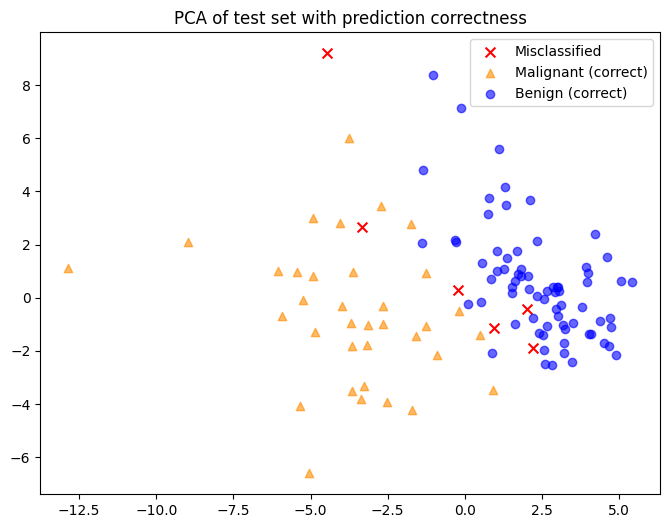

In [ ]:
# Visualise PCA projection with correctness annotations
import matplotlib.pyplot as plt
correct = (y_test == y_pred)
plt.figure(figsize=(8,6))
plt.scatter(X_proj[~correct,0], X_proj[~correct,1], marker='x', label='Misclassified', s=50, c='red')
for cls, lbl in [(1, 'Malignant'), (0, 'Benign')]:
    idx = (y_test == cls) & correct
    plt.scatter(X_proj[idx,0], X_proj[idx,1], label=f'{lbl} (correct)', alpha=0.6, c=('darkorange' if cls==1 else 'blue'), marker=('^' if cls==1 else 'o'))
plt.legend()
plt.title("PCA of test set with prediction correctness")
plt.show()

## Takeaways
 
- Feature scaling plus averaged perceptron delivers a stable linear separator on this dataset without the need for regularisation.
- The confusion matrix highlights where malignant cases could still be missed—worth monitoring with threshold tuning or alternative models.
- PCA indicates the projected clusters are mostly separable; misclassifications tend to sit near the class boundary, suggesting the model is capacity-limited rather than underfit data preprocessing.
 
In practice the strict linear decision surface of a perceptron underfits the nuanced structure of breast cancer data, so modern clinics favour probabilistic linear models such as logistic regression or margin-based support vector machines that offer calibrated uncertainty estimates and stronger robustness.

## Perceptron class implementation
 
The following class encapsulates the exact training loop used above, exposing `fit`, `decision_function`, and `predict` methods so the averaged/pocket perceptron can be reused on future datasets. Provide a validation split via `validation_data` when you want to retain the best-performing "pocket" weights during training.

In [ ]:
class Perceptron:
    """Averaged perceptron with optional pocket weights for binary classification."""
    def __init__(self, n_epochs=1000, lr=0.01, random_state=None, average=True, use_pocket=True):
        self.n_epochs = n_epochs
        self.lr = lr
        self.random_state = random_state
        self.average = average
        self.use_pocket = use_pocket
        self.w_ = None
        self.b_ = None
        self.w_pocket_ = None
        self.b_pocket_ = None
        self.best_acc_ = None
        self.w_avg_ = None
        self.b_avg_ = None

    def fit(self, X_train, y_train, validation_data=None):
        rng = np.random.default_rng(self.random_state)
        y_signed = np.where(y_train == 1, 1, -1)
        n_samples, n_features = X_train.shape
        w = rng.normal(scale=0.01, size=n_features)
        b = 0.0
        w_sum = np.zeros_like(w)
        b_sum = 0.0
        count = 0
        best_w = w.copy()
        best_b = b
        best_acc = -1.0

        X_val, y_val = None, None
        if validation_data is not None:
            X_val, y_val = validation_data
            y_val_signed = np.where(y_val == 1, 1, -1)

        for epoch in range(self.n_epochs):
            perm = rng.permutation(n_samples)
            errors = 0
            for idx in perm:
                xi = X_train[idx]
                yi = y_signed[idx]
                linear_output = np.dot(xi, w) + b
                if yi * linear_output <= 0:
                    w += self.lr * yi * xi
                    b += self.lr * yi
                    errors += 1
                if self.average:
                    w_sum += w
                    b_sum += b
                    count += 1

            if self.use_pocket and validation_data is not None:
                y_val_pred = np.where(X_val @ w + b >= 0, 1, -1)
                acc = np.mean(y_val_pred == y_val_signed)
                if acc > best_acc:
                    best_acc = acc
                    best_w = w.copy()
                    best_b = b
            elif self.use_pocket:
                y_train_pred = np.where(X_train @ w + b >= 0, 1, -1)
                acc = np.mean(y_train_pred == y_signed)
                if acc > best_acc:
                    best_acc = acc
                    best_w = w.copy()
                    best_b = b

            if errors == 0:
                break

        self.w_ = w
        self.b_ = b
        self.w_pocket_ = best_w if self.use_pocket else None
        self.b_pocket_ = best_b if self.use_pocket else None
        self.best_acc_ = best_acc if self.use_pocket else None

        if self.average and count > 0:
            self.w_avg_ = w_sum / count
            self.b_avg_ = b_sum / count
        else:
            self.w_avg_ = None
            self.b_avg_ = None
        return self

    def decision_function(self, X, use="average"):
        if use == "average" and self.w_avg_ is not None:
            return X @ self.w_avg_ + self.b_avg_
        if use == "pocket" and self.use_pocket and self.w_pocket_ is not None:
            return X @ self.w_pocket_ + self.b_pocket_
        return X @ self.w_ + self.b_

    def predict(self, X, use="average"):
        scores = self.decision_function(X, use=use)
        return np.where(scores >= 0, 1, 0)